In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Charter school identities project:<br/> Analyzing Word Embedding Models with word2vec
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018

## Initialize Python

In [20]:
# IMPORTING KEY PACKAGES
'''
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas as pd # for working with dataframes
import numpy as np # for working with numbers
import pickle # For working with .pkl files
from tqdm import tqdm # Shows progress over iterations, including in pandas via "progress_apply"
'''
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector
from ast import literal_eval

In [3]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings
'''
from nltk.corpus import stopwords # for eliminating stop words
stopenglish = list(stopwords.words("english")) # assign list of english stopwords
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign list of common punctuation symbols
punctuations+=['•','©','–'] # Add a few more punctuations also common in web text
import hashlib # For checking for duplicate long strings with minimal memory drain
'''

'\nfrom nltk.corpus import stopwords # for eliminating stop words\nstopenglish = list(stopwords.words("english")) # assign list of english stopwords\nimport string # for one method of eliminating punctuation\npunctuations = list(string.punctuation) # assign list of common punctuation symbols\npunctuations+=[\'•\',\'©\',\'–\'] # Add a few more punctuations also common in web text\nimport hashlib # For checking for duplicate long strings with minimal memory drain\n'

In [4]:
stemmer = PorterStemmer # Makes stemming more accessible
stem = stemmer().stem 
stem("philosophy")

'philosophi'

In [5]:
# FOR ANALYZING THE TEXT
'''
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

import Cython # For parallelizing word2vec
'''

'\nfrom sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially\ncountvec = CountVectorizer(tokenizer=nltk.word_tokenize)\nfrom sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs\ntfidfvec = TfidfVectorizer()\nfrom sklearn.decomposition import LatentDirichletAllocation # for topic modeling\n\nfrom scipy.spatial.distance import cosine # for cosine similarity\nfrom sklearn.metrics import pairwise # for pairwise similarity\nfrom sklearn.manifold import MDS, TSNE # for multi-dimensional scaling\n\nimport Cython # For parallelizing word2vec\n'

In [6]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
sns.despine()

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stem']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
# Define data and model file paths
charters_path = "../../charters_full_2015.pkl" # All text data; only charter schools (regardless if open or not)
wordsent_path = "../data/wem_data.pkl"
phrasesent_path = "../data/wem_data_phrases.pkl"
wem_path = "../data/wem_model.txt"

# Define file paths to existing dicts
ess_path = "../dicts/ess_dict.txt"
prog_path = "../dicts/prog_dict.txt"
rit_path = "../dicts/rit_dict.txt"

# Define file paths for new dicts
ess_valid = "../dicts/ess_valid.txt"
prog_valid = "../dicts/prog_valid.txt"
rit_valid = "../dicts/rit_valid.txt"
ess_polar = "../dicts/ess_polar.txt"
prog_polar = "../dicts/prog_polar.txt"
rit_polar = "../dicts/rit_polar.txt"

## Define helper functions

In [8]:
def quickpickle_load(picklepath, outputvar):
    '''Very time-efficient way to load pickle-formatted objects into Python.
    Uses C-based pickle (cPickle) and gc workarounds to facilitate speed. 
    Input: Filepath to pickled (*.pkl) object.
    Output: Python object (probably a list of sentences or something similar).'''

    output = open(picklepath, 'rb')
    gc.disable() # disable garbage collector

    outputvar = cPickle.load(output)

    gc.enable() # enable garbage collector again
    output.close()
    
    return outputvar

In [9]:
def write_list(file_path, textlist):
    """Writes textlist to file_path. Useful for recording output of parse_school()."""
    
    with open(file_path, 'w') as file_handler:
        for elem in textlist:
            file_handler.write("{}\n".format(elem))
        return    

In [10]:
def load_list(file_path):
    """Loads list into memory. Must be assigned to object."""
    
    textlist = []
    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            textlist.append(line)
            line = file_handler.readline()
    return textlist

In [11]:
def load_dict(custom_dict, file_path):
    """
    Loads in a dictionary from a file.
    Each word is stemmed and lower-cased in preparation for matching with word2vec.
    Adds each entry from the dict at file_path to the defined set custom_dict (the input), 
    which can also be an existing dictionary. This allows the creation of combined dictionaries!
    Multi-word dictionary elements (phrases) are transformed into a single word by
    replacing spaces with underscores, e.g. "college oriented" -> "college_oriented".
    """

    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            line = line.replace("\n", "") # Replace newlines at start, to avoid confusing tokenizers
            linetoks = word_tokenize(line)
            
            if len(linetoks) > 1: # For phrases (>1 word long) in dictionary
                line = [PorterStemmer().stem(word.lower()) for word in linetoks]
                line = "_".join(word for word in line)
                custom_dict.add(line.replace("_","")) # Also add element with no space between words
            else:
                line = PorterStemmer().stem(line.lower()) # For single-word dict elements, just stem it
            
            if "-" in line:
                custom_dict.add(line.replace("-","_")) # If appropriate, also add element that replaces "-" with "_"
                custom_dict.add(line.replace("-","")) # Also add element with no space between words
            
            custom_dict.add(line) # Add line after stemming dictionary entries and eliminating newlines
            line = file_handler.readline() # Look for anything else in that line, add that too
            
    return custom_dict

In [12]:
ess_dict, prog_dict, rit_dict = set(), set(), set()

ess_dict = load_dict(ess_dict, ess_path)
prog_dict = load_dict(prog_dict, prog_path)
rit_dict = load_dict(rit_dict, rit_path)

In [13]:
def make_dicts(paths_list):
    '''Create ideology dictionaries: essentialism, progressivism, and ritualism.
    Input: List of paths to all files holding dictionaries.
    Output: List of dictionaries, each of which is a list of terms.'''
    
    keydicts = [] # Initialize list holding all dicts
    
    for path in paths_list:
        thisdict = set() # Initialize variable holding terms
        thisdict = load_dict(thisdict, path) # Load from file into variable
        keydicts.append(thisdict) # Add dict to list of dicts
    
    #ess_dict, prog_dict, rit_dict, all_ideol, all_dicts = set(), set(), set(), set(), set()

    #all_ideol = load_dict(all_ideol, ess_path)
    #all_ideol = load_dict(all_ideol, prog_path) # For complete ideological list, append second ideological dict
    #all_dicts = load_dict(all_ideol, rit_path) # For complete dict list, append ritual dict terms too

    #ess_dict = load_dict(ess_dict, ess_path)
    #prog_dict = load_dict(prog_dict, prog_path)
    #rit_dict = load_dict(rit_dict, rit_path)
    
    #keydicts = [ess_dict, prog_dict, rit_dict]
    
    print("Lists of key terms (dictionaries) loaded!")
    
    return(keydicts)

In [14]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of dictionary terms with each other, 
    compared to the average cosine similarity score between all the dictionary terms and the total model vocabulary.
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dists = 0
    dict_avg_dist = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=list_dicts[1]).sum())/len(thisdict)
        word_avg_dists += word_avg_dist
    dict_avg_dist = 1 - word_avg_dists/len(list_dicts[1]) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_dist

In [28]:
def clean_textlist(textlist):
    """Removes extraneous spaces: at beginning and end of word2vec-format list of strings, 
    and between two parts of word at start of each line.
    
    Input: list of strings in word2vec format, e.g. ["aardvark .40 .01 .21...\n", "banana .25 .71 .06...\n", ...].
    Output: cleaned list of strings in word2vec format, which ideally should work for word2vec model generation."""
    
    unspaced_text = [textlist[0].replace("\n", "")]

    for oneline in textlist[1:]:
        first, pieces, line = "", [], []
        
        if "\\" in oneline:
            continue # Skip lines with URLs, etc.
        
        for piece in oneline.strip(" ").split(" "): # Remove spaces from beginning and end, then split by spaces
            if piece in ["", " ", "1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10."]:  # ["", " "] or (piece.replace(".", "").isdigit() and literal_eval(piece) >= 1):
                continue # Omit empty or erroneous elements (1.0 or greater)
            elif not piece.replace("-", "").strip("\n").replace(".", "").replace("e", "").isdigit(): # Check if digit (after removing negative signs, decimal points, scientific notation, and newlines)
                first += piece # If not a digit, it's part of the word, so concatenate it with rest of word
            else:
                pieces.append(piece.replace("\n", "")) # If a digit, add it to list of digits in vector

        line = (first + " " + " ".join([piece for piece in pieces])).strip(" ") # Reconstruct vector
        unspaced_text.append(line) # Add to new word2vec text list/ object
    
    return unspaced_text

## Refine & Validate the Dictionaries

In [23]:
# Clear out from file any lines with words containing "\\":
#import fileinput
#for line in fileinput.input(wem_path, inplace=True):
#    if "\\" in line:
#        continue
#    print(line, end='')

In [26]:
wemtext = load_list(wem_path)

In [29]:
wemtext = clean_textlist(wemtext) # Remove problematic spacing, clean
wemtext[:10]

['437125 200',
 'school 0.54740906 -0.14102076 -0.36951113 0.27863705 -0.33514756 -1.3216113 0.5498553 0.7622687 0.042854495 0.5314519 0.4150399 0.010801938 -0.57666856 0.02404766 0.17386927 0.032315925 -0.54653615 -0.23943013 0.47570834 0.5231387 -0.06358967 -0.338586 0.38468817 0.5909768 -0.4200907 -0.32845142 0.50683224 -0.08236562 0.07095169 0.016019939 -0.33010647 -0.201582 0.1197746 -0.05694962 -0.15438943 0.251772 -0.2795471 -0.28692344 -0.33142862 0.15822521 0.365685 -0.61752784 0.17181376 0.38281867 -0.7117497 0.5929273 -0.26011905 0.37736356 -0.20885356 -0.7753023 0.21548323 0.22457688 0.09889056 0.41493672 -0.26319525 0.44334722 0.3507781 0.7177284 0.025196375 1.0469638 -0.02981571 0.10961601 -0.11048064 0.05249125 0.48244613 -0.34386298 0.19575138 -0.386808 -0.6823948 0.261887 0.63092554 -0.46614403 0.5098388 -0.34777167 0.3460378 -0.48610026 0.08029808 -0.51182604 -0.72983176 -0.40187982 0.021676878 -0.26954314 -0.53864753 0.1438191 0.13242154 0.2007379 0.026862105 0.84410

In [30]:
n = 129217
print(len(word_tokenize(wemtext[n])), "\nfor this vector, VS. length of next vector:\n", len(word_tokenize(wemtext[n+1])))
wemtext[n]

201 
for this vector, VS. length of next vector:
 201


'ab 0.110882156 0.036265224 -0.17839006 0.21805526 -0.19264942 -0.031053416 0.1642687 -0.052790254 0.4238053 -0.1655921 0.17526054 -0.13012941 0.114748016 -0.17427869 0.020683682 -0.23821625 -0.049706414 0.12333665 -0.30189162 0.008137494 -0.2975101 0.098811604 -0.019238286 0.19297199 0.018226525 -0.22820088 -0.18226641 -0.1657804 -0.06891812 0.06119596 0.22428644 0.12867261 -0.051268075 0.077176265 0.25280273 0.15124188 0.044861466 -0.120124616 -0.035808347 -0.0029453393 -0.03141373 -0.13077499 -0.13113289 -0.32395968 0.17194782 0.05014926 -0.09877455 -0.016901638 -0.03921734 0.13233386 0.09909349 -0.033909865 0.2697007 0.1144784 -0.029927675 0.19273604 0.03139837 0.026091855 -0.1596437 -0.055325307 0.17582701 0.014133473 0.05685524 0.014489311 -0.040235065 0.16175735 -0.16122448 0.062534206 0.032422427 -0.053784963 0.097097896 -0.011382675 -0.15191095 -0.28994456 -0.13847214 -0.13573635 -0.16916107 -0.1347975 0.04157099 -0.20610096 -0.08618649 0.10802288 0.07602292 0.0016283974 0.080

In [31]:
wemtext[0]

'437125 200'

In [35]:
len(wemtext)

430374

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(wemtext) # Load word2vec model

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-0edb5426501e>", line 1, in <module>
    model = gensim.models.KeyedVectors.load_word2vec_format(wemtext) # Load word2vec model
  File "/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py", line 1436, in load_word2vec_format
    limit=limit, datatype=datatype)
  File "/opt/conda/lib/python3.6/site-packages/gensim/models/utils_any2vec.py", line 171, in _load_word2vec_format
    with utils.smart_open(fname) as fin:
  File "/opt/conda/lib/python3.6/site-packages/smart_open/smart_open_lib.py", line 231, in smart_open
    binary, filename = _open_binary_stream(uri, binary_mode, **kw)
  File "/opt/conda/lib/python3.6/site-packages/smart_open/smart_open_lib.py", line 363, in _open_binary_stream
    raise TypeError('don\'t know how to handl

In [34]:
# dictionary of words in model (may not work for old gensim)
print(len(model.vocab))
list(model.vocab)

NameError: name 'model' is not defined

In [21]:
def clean_dict(thisdict, wem_model, exclusions, dict_length):
    '''Cleans, filters, and validates dictionary using word embeddings model, 
    creating a validated dictionary with number of terms equal to of dict_length.
    Inputs: 
    '''

In [23]:
# Adjust dictionaries to only include terms that appear in the model vocabulary
paths_list = [ess_path, prog_path, rit_path] # Define list of file paths
list_dicts = make_dicts(paths_list) # Load dictionaries

# Define words to clean out from dicts
ess_drop = ['workrel', 'atrisk']
prog_drop = ['problemsolv', 'wholechild']
rit_drop = ['real_world']
drop_lists = [ess_drop, prog_drop, rit_drop]

for thisdict, path, droplist in list(zip(list_dicts, paths_list, drop_lists)):
    print("Removing non-corpus terms from dict at " + str(path))
    print("Initial length of dictionary: " + str(len(thisdict)))
    listdict = list(thisdict)
    for word in listdict:
        if word not in list(model.vocab):
            thisdict.remove(word)
            print("NOT FOUND, REMOVING:\t" + word)
        else:
            print("FOUND, KEEPING:\t\t" + word)
            pass
        
        # Clean out select words from this core dict:
        if word in droplist: # Check if word matches any word in list of words to drop
            print("  Removing " + word)
            thisdict.remove(word) # Remove any words in exclusions list
    thisdict = set(thisdict)

    print("Final length of dictionary: " + str(len(thisdict)))
    print("Dict is now: " + str(thisdict) + "\n")

Lists of key terms (dictionaries) loaded!
Removing non-corpus terms from dict at ../dicts/ess_dict.txt
Initial length of dictionary: 329
FOUND, KEEPING:		mainfram
NOT FOUND, REMOVING:	reduced_pric
NOT FOUND, REMOVING:	prepar_for_colleg
FOUND, KEEPING:		work-rel
FOUND, KEEPING:		equal
NOT FOUND, REMOVING:	observ_on_teacher_state_standard
NOT FOUND, REMOVING:	mathandread
NOT FOUND, REMOVING:	personlearnneedtechnolog
FOUND, KEEPING:		achiev_gap
NOT FOUND, REMOVING:	college_complet
NOT FOUND, REMOVING:	behavior_rule
NOT FOUND, REMOVING:	creditrecoveri
NOT FOUND, REMOVING:	boundforcolleg
NOT FOUND, REMOVING:	feedbacktoteacher
NOT FOUND, REMOVING:	lawyer_servic
NOT FOUND, REMOVING:	social_problem
NOT FOUND, REMOVING:	desperat
NOT FOUND, REMOVING:	recoveriofcredit
NOT FOUND, REMOVING:	collegenrol
FOUND, KEEPING:		at-wil
FOUND, KEEPING:		seminar
FOUND, KEEPING:		college-bound
NOT FOUND, REMOVING:	colleg_bound
FOUND, KEEPING:		disadvantag
NOT FOUND, REMOVING:	lawyer_provid
NOT FOUND, REMOVING:	

NOT FOUND, REMOVING:	back_to_bas
NOT FOUND, REMOVING:	provid_a_lawyer
NOT FOUND, REMOVING:	memori_and_drill
NOT FOUND, REMOVING:	teachforamerica
NOT FOUND, REMOVING:	providalawyer
NOT FOUND, REMOVING:	collegeprep
NOT FOUND, REMOVING:	essentialist
NOT FOUND, REMOVING:	rootinbasic
NOT FOUND, REMOVING:	essentiknowledg
NOT FOUND, REMOVING:	at_wil
NOT FOUND, REMOVING:	math_&_read
NOT FOUND, REMOVING:	basic_educ
NOT FOUND, REMOVING:	code_of_moral_conduct
FOUND, KEEPING:		obedi
NOT FOUND, REMOVING:	parentcontract
FOUND, KEEPING:		quantif
NOT FOUND, REMOVING:	college-complet
NOT FOUND, REMOVING:	collegeori
FOUND, KEEPING:		outcom
FOUND, KEEPING:		vulner
NOT FOUND, REMOVING:	at_risk
NOT FOUND, REMOVING:	ofcolor
FOUND, KEEPING:		apprais
FOUND, KEEPING:		enforc
FOUND, KEEPING:		college-enrol
NOT FOUND, REMOVING:	lawyerservic
FOUND, KEEPING:		militari
FOUND, KEEPING:		respect
NOT FOUND, REMOVING:	teacherreview
FOUND, KEEPING:		drop-out
FOUND, KEEPING:		immigr
FOUND, KEEPING:		reduced-pric
NOT FOUN

NOT FOUND, REMOVING:	projectori
FOUND, KEEPING:		recondit
FOUND, KEEPING:		trivium
FOUND, KEEPING:		theater
NOT FOUND, REMOVING:	constructivi
NOT FOUND, REMOVING:	integrat
FOUND, KEEPING:		sentiment
FOUND, KEEPING:		discuss
NOT FOUND, REMOVING:	inner_truth
NOT FOUND, REMOVING:	intern_school
FOUND, KEEPING:		love
NOT FOUND, REMOVING:	progressivi
FOUND, KEEPING:		unorthodox
NOT FOUND, REMOVING:	spoon-fe
FOUND, KEEPING:		drone
NOT FOUND, REMOVING:	criticthink
FOUND, KEEPING:		rebel
FOUND, KEEPING:		chef
NOT FOUND, REMOVING:	crosscultur
NOT FOUND, REMOVING:	nonconcret
NOT FOUND, REMOVING:	criticthought
FOUND, KEEPING:		drama
FOUND, KEEPING:		self-guid
FOUND, KEEPING:		car
FOUND, KEEPING:		paint
FOUND, KEEPING:		immers
FOUND, KEEPING:		wellb
NOT FOUND, REMOVING:	socio_emot
FOUND, KEEPING:		flora
NOT FOUND, REMOVING:	relattoother
NOT FOUND, REMOVING:	self_relian
FOUND, KEEPING:		interact
NOT FOUND, REMOVING:	learner_center
FOUND, KEEPING:		socio-emot
NOT FOUND, REMOVING:	musicandart
NOT FOUN

NOT FOUND, REMOVING:	singl_sex
FOUND, KEEPING:		teacher
FOUND, KEEPING:		succ
FOUND, KEEPING:		achiev
FOUND, KEEPING:		inform
FOUND, KEEPING:		mark
FOUND, KEEPING:		masteri
FOUND, KEEPING:		attitud
FOUND, KEEPING:		facil
FOUND, KEEPING:		formal
FOUND, KEEPING:		depth
FOUND, KEEPING:		charact
FOUND, KEEPING:		coe
FOUND, KEEPING:		repres
NOT FOUND, REMOVING:	public_polici
FOUND, KEEPING:		progress
FOUND, KEEPING:		scienc
FOUND, KEEPING:		single-sex
FOUND, KEEPING:		valu
FOUND, KEEPING:		research
FOUND, KEEPING:		one
NOT FOUND, REMOVING:	participat
FOUND, KEEPING:		instruct
NOT FOUND, REMOVING:	english_as_second_languag
FOUND, KEEPING:		program
FOUND, KEEPING:		aptitud
NOT FOUND, REMOVING:	infu
FOUND, KEEPING:		ideal
NOT FOUND, REMOVING:	befor_care
FOUND, KEEPING:		blend
FOUND, KEEPING:		involv
FOUND, KEEPING:		empow
NOT FOUND, REMOVING:	researchbas
FOUND, KEEPING:		today
FOUND, KEEPING:		student
NOT FOUND, REMOVING:	factfind
FOUND, KEEPING:		tenaci
FOUND, KEEPING:		inten
FOUND, KEEPING:	

In [ ]:
for thisdict in list_dicts:
    print(dict_cohere(thisdict, model))

In [79]:
model.most_similar(list_dicts[0], topn=20) # ess

[('metalinguist_hypothesi', 0.9276553392410278),
 ('doa', 0.9266489744186401),
 ('baehr_2011b', 0.9202886819839478),
 ('muennix_said', 0.9166758060455322),
 ('emergency;', 0.9166485667228699),
 ('near-', 0.9147078394889832),
 ('survivorship_bia', 0.9135845899581909),
 ('maslow_hierarchi', 0.9131898880004883),
 ('ofclass', 0.9128526449203491),
 ('insurmount_challeng', 0.9119694828987122),
 ('dawdl', 0.9117785096168518),
 ('417,311', 0.91152024269104),
 ('lessons/act', 0.9112095832824707),
 ('thatmay', 0.9110066890716553),
 ('22,000.00', 0.9110027551651001),
 ('evaluation/reevalu', 0.9108059406280518),
 ('sc.5.p.13.2', 0.910629153251648),
 ('short-hand', 0.9103440642356873),
 ('behavioral/psychiatr', 0.9103240966796875),
 ('educa¬t', 0.9102213382720947)]

In [80]:
model.most_similar(list_dicts[1], topn=20) # prog

[('education.\u200b', 0.9251624345779419),
 ('andvalu', 0.9247552752494812),
 ('andstrategi', 0.9206980466842651),
 ('līberātu', 0.9194883108139038),
 ('andchalleng', 0.9190690517425537),
 ('andmaxim', 0.9189148545265198),
 ('metalinguist_hypothesi', 0.918434202671051),
 ('toincreas', 0.9165937900543213),
 ('lessons/act', 0.9163439273834229),
 ('baehr_2011b', 0.9149503111839294),
 ('forlearn', 0.9146549105644226),
 ('analyt_and_problem-solv', 0.912956178188324),
 ('5cs/habit', 0.9122759103775024),
 ('hrough', 0.9113765358924866),
 ('knowledge-work', 0.9096581339836121),
 ('issue/problem', 0.9093902707099915),
 ('personaland', 0.9088993072509766),
 ('latin-american_cultur', 0.9083201885223389),
 ('re-defin', 0.9079111814498901),
 ('th.1.f.3.1', 0.9074324369430542)]

In [35]:
model.most_similar(list_dicts[2], topn=20) # rit

[('baehr_2011b', 0.9002017378807068),
 ('anti-bias_anti-racist', 0.8913339376449585),
 ('munic', 0.8862725496292114),
 ('metalinguist_hypothesi', 0.885473370552063),
 ('ipc_and_imyc', 0.8828707933425903),
 ('thene', 0.8824278712272644),
 ('teacher/class', 0.8806991577148438),
 ('howth', 0.8805593252182007),
 ('expecta-', 0.8801945447921753),
 ('andchalleng', 0.8796428442001343),
 ('student-cent_inquiry-bas', 0.8788137435913086),
 ('approach_to_education—research', 0.8785804510116577),
 ('developmental-interact_approach', 0.8785141706466675),
 ('ahigh', 0.8783534169197083),
 ('child-centr', 0.8782345056533813),
 ('thecours', 0.8778669834136963),
 ('highexpect', 0.877463698387146),
 ('lessons/act', 0.8766782283782959),
 ('research-bas_pedagogi', 0.876295804977417),
 ('peer-mentor', 0.8758668303489685)]

In [36]:
model.most_similar(positive=list_dicts[0], negative=list_dicts[1], topn=20) # ess - prog

[('grade/posit', 0.3184661269187927),
 ('nbhvarsitych_yahoo.com', 0.2934500277042389),
 ('http_//www.youtube.com/embed/rstotrxdoqg', 0.27947884798049927),
 ('2013-02-20_parent_teacher_student_coalition_agenda.pdf',
  0.2703778147697449),
 ('wclayasuprep.weebly.com', 0.26753416657447815),
 ('becom_a_kippster', 0.25791293382644653),
 ('1,514,043', 0.25642746686935425),
 ('15,636', 0.25472795963287354),
 ('2018-03-22t14:33:30z', 0.2545211911201477),
 ('hcordova_newamericaschoolnm.org', 0.25319141149520874),
 ('http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg',
  0.2528453469276428),
 ('02.01.18_ed', 0.2506014406681061),
 ('process1_temp.php', 0.24953339993953705),
 ('http_//www.universityofcalifornia.edu/admissions/', 0.24945060908794403),
 ('sourc_the_star-ledg', 0.24655720591545105),
 ('105,141', 0.24613776803016663),
 ('may07', 0.24503378570079803),
 ('assignment_page_help_card.pdf', 0.24145573377609253),
 ('produkt_25/35', 0.2400006800889969),
 ('627,23

In [37]:
model.most_similar(positive=list_dicts[1], negative=list_dicts[0], topn=20) # prog - ess

[('storytel_puppetri', 0.8212826251983643),
 ('richli', 0.8124901056289673),
 ('inquisit_mind', 0.8005656003952026),
 ('spin_wool', 0.7864401340484619),
 ('biodynam_farm', 0.7846383452415466),
 ('yoga_medit', 0.7844189405441284),
 ('expressionist', 0.7833541631698608),
 ('mask-mak', 0.7832543253898621),
 ('wild_side', 0.7830678820610046),
 ('instil_a_life-long', 0.7791727781295776),
 ('music-mak', 0.7784420847892761),
 ('`āina', 0.7777569890022278),
 ('dig_in_the_dirt', 0.7775033712387085),
 ('art-fil', 0.777478814125061),
 ('inclin_toward', 0.7763050198554993),
 ('andlearn', 0.7759912610054016),
 ('spatial_interperson', 0.7744860649108887),
 ('andinterest', 0.7734830975532532),
 ('enliven', 0.7731762528419495),
 ('ephemer', 0.7728333473205566)]

In [ ]:
# Define lists of word vectors to exclude from automatic, vectorized dictionary development:
# Line key to correspong dictionary: Line 1 = ess_dict, Line 2 = prog_dict, Line 3 = rit_dict (empty for now because not used)
ess_exclude = ['thatmay', 'metalinguist_hypothesi', 'doa', 'caregivers\x92', 'baehr_2011b', 'awhol', 'muennix_said', 'howth', 'themslev', 'contol', 'ahigh', 'near-', 'vitti_said', 'aparticular', '417,311', 'educa¬t', 'cadet_sidlowski', 'svrcswill']
prog_exclude = ['andvalu', 'inwhich', 'andinspir', 'andstrategi', 'andchalleng', 'tolearn', 'education-an', 'education.\u200b', '5cs/habit', 'līberātu', 'anddetermin', 'waysto', 'andmaxim', 'nutur', 'toincreas', 'andlearn', 'andinterest', 'p21_framework', 'metalinguist_hypothesi', 'andskil', 'neededto', 'pyd', 'samr', 'andcr', 'november-', 'baehr_2011b', 'andshar', 'astrong', 'school/hom_partnership']
rit_exclude = ['student-cent_inquiry-bas', 'child-centr', 'international-mind', 'education—an', '5cs/habit', 'andchalleng', 'inwhich', 'andstrategi', 'anddetermin', 'warm/strict', 'p21_framework', 'andinspir', 'ipc_and_imyc', 'andvalu', 'thene', 'p4c', 'andskil', 'expecta-', 'personaland', 'outside-the-box', 'self-esteem_and_self-confid', 'educationalenviron', 'helpingstud', 'self-inquiri', 'lmm_strive', 'līberātu', 'perspective-tak', 'perceptual-motor', 'pyd', 'self-appreci', 'academicand', 'enki', 'iroar', 'andcr', 'enhanc_their_self-concept', 'learn-', 'studentsto', 'learningexperi', 'curios_and_thirst', 'parents—to', 'waysto', 'tcmpc', 'samr']

exclude_lists = [ess_exclude, prog_exclude, rit_exclude]
exclusions = ess_exclude + prog_exclude + rit_exclude

In [ ]:
# SHOW DICTS AT 50 BEFORE ADDS (don't change the actual contents)
n = 50 # Define half the final length of dictionaries
fiftydicts = []

for thisdict in list_dicts: #, badlist in list(zip(list_dicts, exclude_lists)):
    copydict = thisdict
    
    # Remove least central dict elements to reduce dictionary to length n:
    while len(copydict) > int(n):
        outword = model.doesnt_match(copydict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        copydict.remove(outword)
    
    addlist = [word[0] for word in model.most_similar(copydict, topn=int(n*2))] # Find terms similar to thisdict
    print("Dictionary reduced to 50 terms: \n", copydict)
    print(str(n*2) + " most similar terms to add: \n", addlist)
    print()
        
    fiftydicts.append(copydict)

In [ ]:
for thisdict in fiftydicts:
    print(dict_cohere(thisdict, model))

In [ ]:
list_dicts_polar = list_dicts # For comparing dicts against each other

### Validate dictionaries using within-dictionary comparisons

In [ ]:
n = 50 # Define half the final length of dictionaries

list_dicts2 = [] # Initialize new list of dictionaries

for thisdict, badlist in list(zip(list_dicts, exclude_lists)):
    # Remove least central dict elements to reduce dictionary to length n:
    removelist = []
    while len(thisdict) > int(n):
        outword = model.doesnt_match(thisdict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        thisdict.remove(outword)
        removelist.append(outword)
    
    # Add new dict elements based on shared direction of remaining (most central) elements, avoiding words in exclusions list
    addlist = model.most_similar(thisdict, topn=int(n+int(len(badlist)))) # Find terms similar to thisdict
    addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    for word in addlist:
        #if any(badword in word for badword in badlist):
        if word in badlist: # Check if word matches any word in exclusions list
            #print("  Removing " + word)
            addlist.remove(word) # Remove any words in exclusions list
            #addlist.append(model.most_similar(thisdict, topn=1))
    
    # Add new words to dict:
    for word in addlist:
        thisdict.add(word) # Take only word name, not similarity score
    
    # Remove peripheral words until dictionary is of length n*2:
    while len(thisdict) > int(n*2):
        outword = model.doesnt_match(thisdict)
        thisdict.remove(outword)
        removelist.append(outword)
    
    print("REMOVED: " + str([word for word in removelist]))
    print("ADDED: " + str([tup for tup in addlist]), "\n")
    
    print(str(len(thisdict)) + "-TERM DICT:\n" + str([word for word in thisdict]) + "\n")
    
    list_dicts2.append(thisdict)

In [88]:
list_dicts

[{'addict_to_methamphetamin',
  'adverselyaffect',
  'ahigh',
  'ambival',
  'anti-bias_anti-racist',
  'approach_to_education—research',
  'at-risk',
  'at-wil',
  'attenu',
  'back-to-bas',
  'cataton',
  'childdevelop',
  'cisgend',
  'college-enrol',
  'college-ori',
  'conceal_handgun',
  'contend',
  'contol',
  'correct',
  'credit-recoveri',
  'cue',
  'danger',
  'decisionmak',
  'demand',
  'differ-',
  'disciplin',
  'drop-out',
  'expecta-',
  'frpl',
  'glorif',
  'good/bad',
  'hierarchi',
  'hpv/hiv/aid',
  'i.q',
  'ideat_fluenci',
  'implement',
  'impoverish',
  'indic',
  'indisput',
  'inheritor',
  'irrefut',
  'job-rel',
  'life-threaten_reaction',
  'liveri',
  'mainfram',
  'maladapt_behavior',
  'manner_as_non-dis',
  'measur',
  'meddl',
  'methamphetamin_abus',
  'neg_connot',
  'neurotransmitt_in_the_brain',
  'non-avers',
  'non-complet',
  'non-product',
  'nonrespons',
  'obedi',
  'outcom',
  'over-stress',
  'paper-and-pencil',
  'passeng_truck',
  'pee

In [67]:
model.most_similar("contol")

[('life-threaten_reaction', 0.8820400238037109),
 ('caregivers\x92', 0.8753265142440796),
 ('threaten_or_inflict', 0.8749681115150452),
 ('hpv/hiv/aid', 0.8744922876358032),
 ('victims/complain', 0.8725622892379761),
 ('maslow_hierarchi', 0.8723107576370239),
 ('ofthemselv', 0.8720705509185791),
 ('seem_trivial', 0.8706842660903931),
 ('student‟', 0.8704628348350525),
 ('untreat_depress', 0.8704520463943481)]

In [73]:
for thisdict in list_dicts:
    print(len(thisdict), "\t", round(dict_cohere(thisdict, model), 5))

100 	 0.61104
100 	 0.69709
100 	 0.66998


In [86]:
# Save new dicts to disk: within-dict comparisons
#valid_paths = [ess_valid, prog_valid, rit_valid]

#for thisdict, filepath in list(zip(list_dicts, valid_paths)):
#    write_list(filepath, thisdict)

### Validate dictionaries using cross-dictionary comparisons

In [233]:
n = 50 # Define half the final length of dictionaries

for thisdict, badlist, dictname in list(zip(list_dicts_polar, exclude_lists, ['ess', 'prog', 'rit'])):
    # Remove least central dict elements to reduce dictionary to length n:
    removelist = []
    while len(thisdict) > int(n):
        outword = model.doesnt_match(thisdict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        thisdict.remove(outword)
        removelist.append(outword)
    
    # Add new dict elements based on shared direction of remaining (most central) elements, avoiding words in exclusions list
    if dictname=='ess':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[2], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    if dictname=='prog':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[0], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    if dictname=='rit':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[1], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    for word in addlist:
        #if any(badword in word for badword in badlist):
        if word in badlist: # Check if word matches any word in exclusions list
            print("  Removing " + word)
            addlist.remove(word) # Remove any words in exclusions list
            #addlist.append(model.most_similar(thisdict, topn=1))
    
    # Add new words to dict:
    for word in addlist:
        thisdict.add(word) # Take only word name, not similarity score
    
    # Remove peripheral words until dictionary is of length n*2:
    while len(thisdict) > int(n*2):
        outword = model.doesnt_match(thisdict)
        thisdict.remove(outword)
        removelist.append(outword)
    
    print("REMOVED: " + str([word for word in removelist]))
    print("ADDED: " + str([tup for tup in addlist]), "\n")
    
    print(str(len(thisdict)) + "-TERM DICT:\n" + str([word for word in thisdict]) + "\n")

REMOVED: ['wclayasuprep.weebly.com', 'sebastian_junger', 'm.g', '2017-12-26t05:11:12+00:00', 'isplacedwithsitedesigner=tru', '\ue00c', 'academ_success/api', 'http_//parnassusprep.com/wp-content/uploads/2018/04/harkness-table-1-150x150.jpg', 'russo_nicol', 'produkt_3/7', 'lujan-ramirez_jesu', '2017-09-29t11:10:49+00:00', 'stewart_michael', 'tues-w', 'nbhvarsitych_yahoo.com', 'http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0080-150x150.jpg', 'omar_roja', 'http_//roe.lifeschools.net/apps/news/article/593230']
ADDED: ['26,078.00', 'sebastian_junger', 'ashley.short_chavezschools.org', 'grade/posit', 'http_//roe.lifeschools.net/apps/news/article/593230', 'http_//www.youtube.com/embed/rstotrxdoqg', 'anna_salzberg', '240k', 'isplacedwithsitedesigner=tru', 'g‐mg.3', 'http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg', 'http_//capri.campbellusd.org/news/school-news/sbac-testing-0', 'x4401', 'http_//parnassusprep.com/wp-content/uploads/2018/04/harknes

REMOVED: ['significan', 'coe', 'co-e', 'aftercar', 'hybrid', 'esl', 'elementari', 'virtual', 'quest', 'tutor', 'mark', 'charter', 'middl', 'inform', 'meet', 'prep', 'graduat', 'high', 'facil', 'after-car', 'school', 'before-car', 'public', 'elect', 'creed', 'patriot', 'author', 'staff', 'upgrad', 'proud', 'smart', 'tough', 'stori', 'read', 'scienc', 'aptitud', 'restraint', 'math', 'teacher', 'track', 'acceler', 'pride', 'imag', 'attend', 'today', 'year', 'program', 'blend', 'single-sex', 'product', 'educ', 'aspir', 'profession_develop', 'surpass', 'histori', 'commun', 'digniti', 'neg', 'extend', 'reward', 'dream', 'decid', 'modern', 'foundat', 'civic', 'opportunit', 'autonom', 'courag', 'balanc', 'loyalti', 'solid', 'mission', 'beforecar', 'train', 'system', 'number', 'except', 'support', 'direct', 'citizen', 'repres', 'chang', 'simpl', 'cours', 'build', 'complet', 'assign', 'studi', 'one', 'life', 'world', 'leader', 'person', 'children', 'student', 'formal', 'pattern', 'organ', 'exerc

In [234]:
for thisdict in list_dicts_polar:
    print(dict_cohere(thisdict, model))

0.133535630226
0.676271224403
0.171500780296


In [ ]:
# Save new dicts to disk: between-dict comparisons
polar_paths = [ess_polar, prog_polar, rit_polar]

for thisdict, filepath in list(zip(list_dicts_polar, polar_paths)):
    write_list(filepath, thisdict)    

In [299]:
model.most_similar(['high-perform','high-progress','top-scor','outscor_their_peer','significantli_out-perform','beating-the-odd','chievement',\
                             '*high-poverti','economicallydisadvantag','at-_risk','charter/commun',\
                             'traditional-school','quasi-militari','subjectarea','e-stem','certa_assess',\
                             'human-capit','futureprofit',\
                             'irrefut','thebiggest'])

[('⎫', 0.9196736216545105),
 ('antioch-area', 0.9187646508216858),
 ('363k', 0.915664553642273),
 ('7,452', 0.9145717620849609),
 ('1,595', 0.913711428642273),
 ('sub-\xad‐profici', 0.913135290145874),
 ('1,060', 0.91275954246521),
 ('michel_beyronneau', 0.9122559428215027),
 ('communityearth', 0.9118464589118958),
 ('interfund_balanc', 0.9109219312667847)]

In [298]:
# Find cosine distance between two given word vectors
print(model.similarity('college-prep','discipli')) # these two are close to essentialism
print(model.similarity('emot', 'curios')) # these two are close to progressivism

0.4295
0.398092


In [38]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                               'data-driven', 'market', 'research', 'research-bas', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'problem-solv', 'natur']

In [37]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('standards/common', 0.6963038444519043), ('mcf', 0.6911126375198364), ('state-adopt', 0.6644211411476135), ('common-cor', 0.6605211496353149), ('andinstruct', 0.6604572534561157), ('kc4', 0.655948281288147), ('core-bas', 0.6558995246887207), ('state-standard', 0.6558359265327454), ('state-develop', 0.6489849090576172), ('withstat', 0.6473742127418518)]

[('child—phys', 0.7254108786582947), ('fine/gross', 0.7228469848632812), ('social/', 0.7095009088516235), ('andacadem', 0.7077302932739258), ('social/interperson', 0.7069666385650635), ('student—academ', 0.702161431312561), ('cognitively.', 0.6905182600021362), ('developphys', 0.68888258934021), ('pre-academ', 0.6788109540939331), ('disabilities—ar', 0.6785998344421387)]


In [41]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
prog_words = model.most_similar(progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in progressivism:
    prog_words.append(word)
print(prog_words[:20])

['deeper', 'acquir', 'appreci', 'disciplin', 'real-world', 'awar', 'cognit', 'trait', 'human', 'mind', 'differenti', 'defin', 'strengthen', 'play', 'authent', 'self-confid', 'show', 'studentsõ', 'explor', 'scientif']


In [42]:
ess_words = model.most_similar(essentialism, topn=50) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

['acceler', 'blend', 'compon', 'rich', 'intens', 'sequenc', 'infus', 'coursework', 'framework', 'proven', 'college-preparatori', 'across', 'key', 'student-cent', 'fulli', 'industri', 'aim', 'util', 'self-pac', 'profici']


In [43]:
# construct an combined dictionary
phil_words = ess_words + prog_words

## Analyzing the Model: Creating a Binary

In [44]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('emot', word) for word in phil_words]
y = [model.similarity('align', word) for word in phil_words]

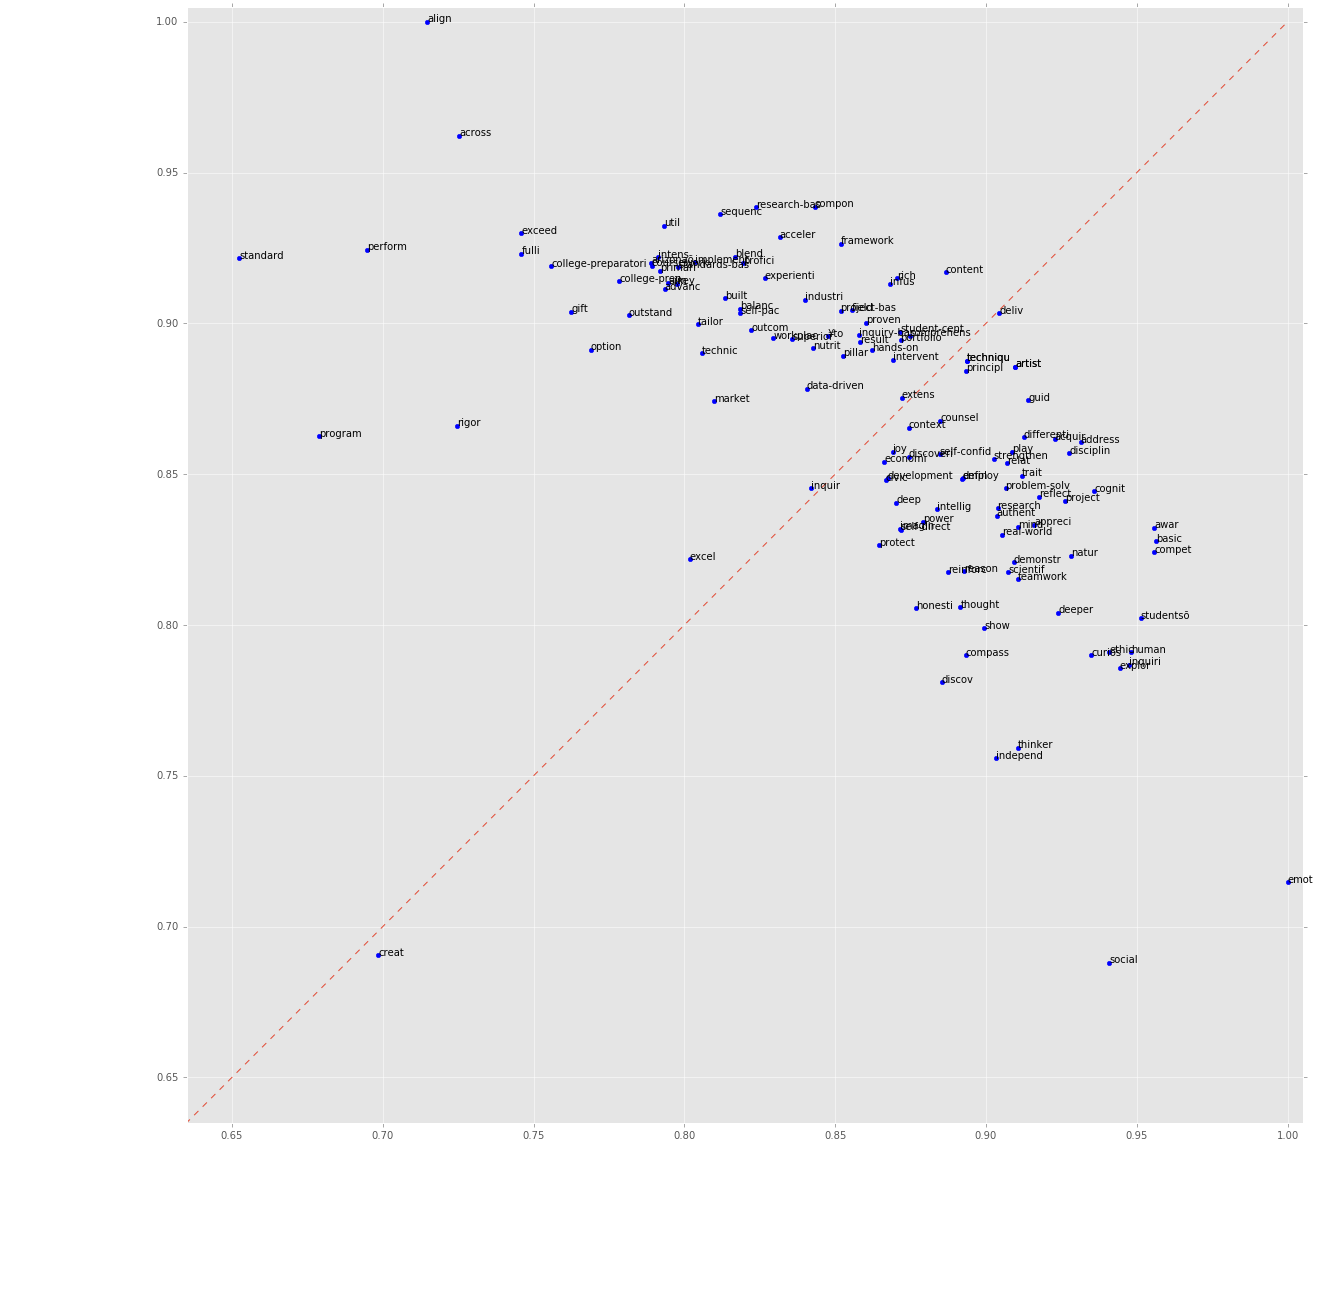

In [45]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors